<a href="https://colab.research.google.com/github/tawsif5001/brain_tumor_detection_app-using-cnn/blob/main/Inseption_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
# Explicitly import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# Step 1: Define Paths and Parameters
train_dir = '/content/drive/MyDrive/dataset/train'
val_dir = '/content/drive/MyDrive/dataset/val'
test_dir = '/content/drive/MyDrive/dataset/test'

img_size = (299, 299)  # InceptionV3 input size
batch_size = 32
epochs = 20
num_classes = 4

In [ ]:
# Step 2: Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2563 images belonging to 4 classes.
Found 2563 images belonging to 4 classes.
Found 2563 images belonging to 4 classes.


In [ ]:
# Step 3: Load Pre-trained InceptionV3 Model and Fine-tune
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# Step 4: Train the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/20
81/81 [==============================] - 1689s 21s/step - loss: 0.8150 - accuracy: 0.6766 - val_loss: 0.4744 - val_accuracy: 0.8151
Epoch 2/20
81/81 [==============================] - 726s 9s/step - loss: 0.5253 - accuracy: 0.8045 - val_loss: 0.4026 - val_accuracy: 0.8385
Epoch 3/20
81/81 [==============================] - 734s 9s/step - loss: 0.4642 - accuracy: 0.8248 - val_loss: 0.3408 - val_accuracy: 0.8712
Epoch 4/20
81/81 [==============================] - 735s 9s/step - loss: 0.4222 - accuracy: 0.8400 - val_loss: 0.3297 - val_accuracy: 0.8712
Epoch 5/20
81/81 [==============================] - 732s 9s/step - loss: 0.4100 - accuracy: 0.8424 - val_loss: 0.3374 - val_accuracy: 0.8595
Epoch 6/20
20/81 [======>.......................] - ETA: 4:50 - loss: 0.3736 - accuracy: 0.8594

In [ ]:
# Step 5: Evaluate the Model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy:.2f}")


81/81 ━━━━━━━━━━━━━━━━━━━━ 16s 201ms/step - accuracy: 0.9159 - loss: 0.1966
Validation Accuracy: 0.91


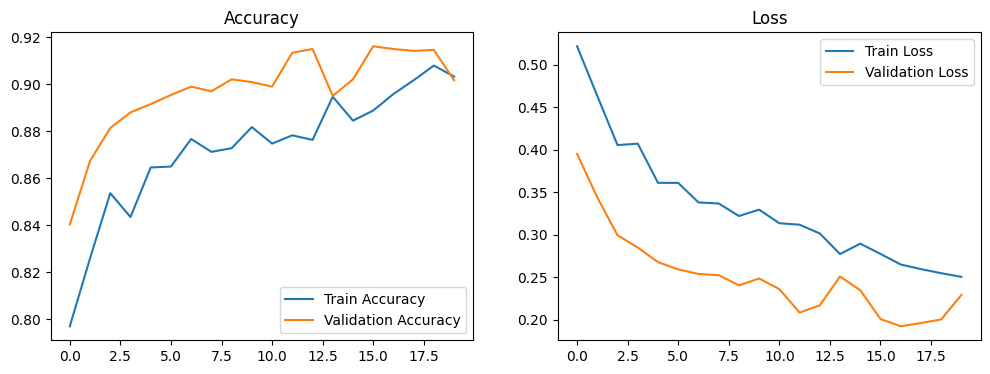

In [ ]:
# Step 6: Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
# Step 7: Classification Report and Confusion Matrix
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 274ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.89      0.98      0.94       603
  meningioma       0.96      0.83      0.89       620
     notumor       0.92      0.93      0.92       690
   pituitary       0.90      0.92      0.91       650

    accuracy                           0.91      2563
   macro avg       0.92      0.91      0.91      2563
weighted avg       0.92      0.91      0.91      2563



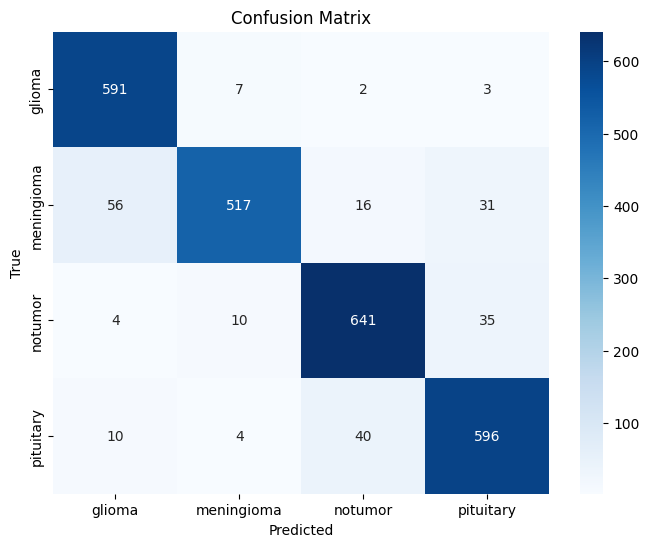

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Step 8: Predict Function for New MRI Images
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_image(img_path):
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    class_names = list(train_generator.class_indices.keys())
    predicted_class = class_names[np.argmax(prediction)]
    return predicted_class, np.max(prediction)

In [ ]:
# Example usage
img_path = '/content/drive/MyDrive/dataset/test/meningioma/Te-me_0068.jpg'
predicted_class, confidence = predict_image(img_path)
print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 46s 46s/step
Predicted Class: meningioma, Confidence: 0.80


In [ ]:
# Example usage
img_path = '/content/drive/MyDrive/dataset/test/pituitary/Te-pi_0150.jpg'
predicted_class, confidence = predict_image(img_path)
print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Class: pituitary, Confidence: 1.00


In [ ]:
# Example usage
img_path = '/content/drive/MyDrive/dataset/train/notumor/Te-noTr_0008.jpg'
predicted_class, confidence = predict_image(img_path)
print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Class: notumor, Confidence: 0.73


In [ ]:
# Example usage
img_path = '/content/drive/MyDrive/dataset/test/glioma/Te-glTr_0009.jpg'
predicted_class, confidence = predict_image(img_path)
print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Class: glioma, Confidence: 0.99
